In [2]:
import os
from dotenv import load_dotenv

load_dotenv()

GOOGLE_API_KEY = os.environ.get("GOOGLE_API_KEY")

In [5]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model = "gemini-2.0-flash", google_api_key=GOOGLE_API_KEY, temperature= 0)
llm

ChatGoogleGenerativeAI(model='models/gemini-2.0-flash', google_api_key=SecretStr('**********'), temperature=0.0, client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x12986a6d0>, default_metadata=(), model_kwargs={})

In [6]:
def multiply(a,b):
    ''' Multiply two numbers
    Arg:
    a: first int
    b: second int
    '''
    return a*b

def divide(a, b):
    ''' Divide two numbers
    a: first int
    b: second int
    '''
    return a//b

def add(a, b):
    ''' Adds two numbers
    a: first int
    b: second int
    ''' 
    return a+b

llm_with_tools = llm.bind_tools([multiply, add, divide])

In [19]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, AnyMessage, HumanMessage

sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs")



def tool_calling_agent(state: MessagesState):
    return {"messages" : [llm_with_tools.invoke([sys_msg] + state["messages"])]}



In [21]:
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

builder = StateGraph(MessagesState)
builder.add_node("llm_call", tool_calling_agent)
builder.add_edge(START, "llm_call")
builder.add_node("tools", ToolNode([multiply, divide, add]))
builder.add_conditional_edges("llm_call", tools_condition)
builder.add_edge("tools", "llm_call")
react_graph = builder.compile()

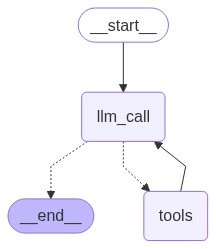

In [17]:
react_graph

In [23]:
messages = [HumanMessage(content="Add 2 and 3. Multiply the output by 2, divide the output by 5")]
messages= react_graph.invoke({"messages": messages})

In [24]:
messages

{'messages': [HumanMessage(content='Add 2 and 3. Multiply the output by 2, divide the output by 5', additional_kwargs={}, response_metadata={}, id='a6c7ddff-2e0c-4467-b0c9-c94f53dc1270'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'add', 'arguments': '{"b": 3.0, "a": 2.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--48cd937c-f83d-438e-8dd1-9d06fcc23c9a-0', tool_calls=[{'name': 'add', 'args': {'b': 3.0, 'a': 2.0}, 'id': '40d1b2ac-ebe7-4e57-9657-d56b70eabc15', 'type': 'tool_call'}], usage_metadata={'input_tokens': 94, 'output_tokens': 5, 'total_tokens': 99, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='5.0', name='add', id='e4312f39-a018-4580-8ceb-a4c9570386ad', tool_call_id='40d1b2ac-ebe7-4e57-9657-d56b70eabc15'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"b"

In [25]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 2 and 3. Multiply the output by 2, divide the output by 5
================================== Ai Message ==================================
Tool Calls:
  add (40d1b2ac-ebe7-4e57-9657-d56b70eabc15)
 Call ID: 40d1b2ac-ebe7-4e57-9657-d56b70eabc15
  Args:
    b: 3.0
    a: 2.0
================================= Tool Message =================================
Name: add

5.0
================================== Ai Message ==================================
Tool Calls:
  multiply (966a4934-8f8f-4317-8b31-271332fe6bf2)
 Call ID: 966a4934-8f8f-4317-8b31-271332fe6bf2
  Args:
    b: 2.0
    a: 5.0
================================= Tool Message =================================
Name: multiply

10.0
================================== Ai Message ==================================
Tool Calls:
  divide (a54190b4-7890-4b2f-b767-18baa2f4aea2)
 Call ID: a54190b4-7890-4b2f-b767-18baa2f4aea2
  Args:
    b: 5.0
    a: 10.0
====

In [26]:
os.environ['LANGCHAIN_PROJECT'] = "langchain_academy"
